In [1]:
import pandas as pd
from dask import dataframe as dk
import numpy as np
#!pip install pandas --upgrade
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest':  bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv', dtype=data_types)

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
poverty = pd.read_csv('poverty.csv')
poverty = poverty.drop('COMMUNITY AREA NAME', 1)
poverty.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [3]:
#  Remove unwanted columns from the data
# Add 'Date' back in when RJ fixes the datetime converter
useful_columns = ['IUCR', 'Location Description', 'Arrest', 'Domestic', 'Community Area', 'Year']
data_full = df[useful_columns]

In [4]:
# Merge with the poverty dataframe
data_full = data_full.rename(columns={'Community Area': 'Community Area Number'})
data_full = pd.merge(data_full, poverty, how='right', on='Community Area Number')

In [5]:
# Also resample to a smaller size for now
num_records = 100000
data = data_full.sample(num_records, replace=True)
data = data.dropna()
data.tail()

,IUCR,Location Description,Arrest,Domestic,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
5252395,1330,AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA,True,False,56.0,2011,2.6,8.8,11.3,19.3,38.1,26353,32.0
4526961,0810,STREET,False,False,53.0,2006,3.3,25.9,19.4,20.5,42.1,16563,62.0
1810897,0460,RESIDENTIAL YARD (FRONT/BACK),False,False,67.0,2014,4.8,34.4,35.9,26.3,40.7,11317,89.0
1095890,0520,STREET,False,True,23.0,2011,14.8,33.9,17.3,35.4,38.0,13781,85.0
3661754,0484,"SCHOOL, PUBLIC, BUILDING",True,False,66.0,2008,7.6,27.9,17.1,31.2,40.6,13231,80.0


In [6]:
d_subset = data
dummy_vars = ['Year', 'IUCR', 'Location Description', 'Community Area Number']
# Takes about 2 minutes to run on all records, takes much less time to run on subset of 1 or 2 million
data = pd.get_dummies(d_subset, columns=dummy_vars, drop_first=True, sparse=True)

In [7]:
from sklearn.cross_validation import train_test_split

dep_var = ['Arrest']
indep_var = data.columns.values
indep_var = [x for x in indep_var if x not in dep_var]
X = data[indep_var]
y = data[dep_var]
# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
from sklearn import linear_model
lasso_alphas = [0.00001, 0.0001, 0.001, 0.01, 0.02]
clf = linear_model.LassoCV(n_alphas=len(lasso_alphas), alphas=lasso_alphas, n_jobs = -1)
clf.fit(X_train, y_train)

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.02], copy_X=True, cv=None,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=5, n_jobs=-1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [9]:
from sklearn import metrics
# Print the r^2 value for the lasso function
print clf.score(X_test, y_test)

0.553238442891


In [10]:
# Create new variables by thresholding
threshold = 0.1
print len(clf.coef_)
print clf.alpha_
new_vars = [indep_var[x] for x, val in enumerate(clf.coef_) if abs(val) > threshold]
print len(new_vars)

517
1e-05
225


In [11]:
lasso = linear_model.Lasso(alpha=clf.alpha_)
X_train_new = X_train[new_vars]
print X_train_new.shape
X_test_new = X_test[new_vars]
print X_test_new.shape
lasso.fit(X_train_new, y_train)
print lasso.score(X_test_new, y_test)

(60131, 225)
(29618, 225)
0.549773302601


In [12]:
# Also resample to a smaller size for now
num_records = 300000
data = data_full.sample(num_records, replace=True)
data = data.dropna()
data.tail()

,IUCR,Location Description,Arrest,Domestic,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
3368732,1506,STREET,True,False,38.0,2007,3.3,29.3,24.3,15.9,39.5,23472,57.0
3781079,0810,PARKING LOT/GARAGE(NON.RESID.),False,False,32.0,2007,1.5,14.7,5.7,3.1,13.5,65526,3.0
4738489,2017,SIDEWALK,True,False,26.0,2009,9.4,41.7,25.8,24.5,43.6,10934,92.0
905962,1110,OTHER,False,False,68.0,2009,3.8,46.6,28.0,28.5,42.5,11888,94.0
5361499,0460,STREET,False,False,50.0,2003,1.5,21.6,22.8,13.1,38.6,20588,51.0


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
# best logisitc regression from GridSearchCV in file: "Crime Prediction.ipynb"
logr = LogisticRegression(C=10, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logr.fit(X_train_new, y_train)

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [14]:
logr.score(X_test_new, y_test)

0.86781686812073744

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Arrest', 'No Arrest'], rotation=45)
    plt.yticks(tick_marks, ['Arrest', 'No Arrest'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    predictions = [x[1] for x in predictions]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


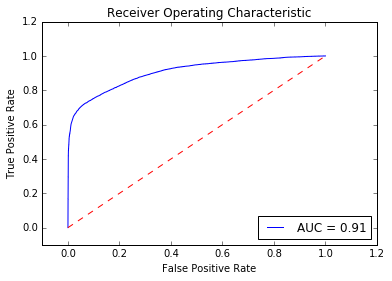

In [21]:
# ROC curve
logr.fit(X_train_new, y_train)
prediction = logr.predict(X_test_new)
plot_roc(logr)

[[19489  1613]
 [ 2302  6214]]


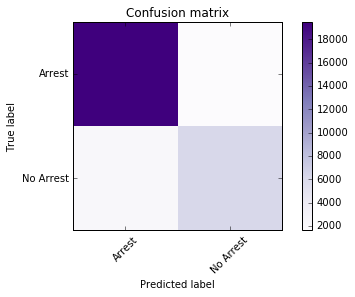

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, cmap=plt.cm.Purples)

In [44]:
%matplotlib inline
# Only run if you want to generate the lasso graph
from sklearn import linear_model
lasso_coeff = {}
for alpha in lasso_alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_coeff[alpha] = lasso.coef_
lpd = pd.DataFrame.from_dict(lasso_coeff, orient='index', )
lpd.columns = data.columns[1:]
lpd=lpd.sort_index()

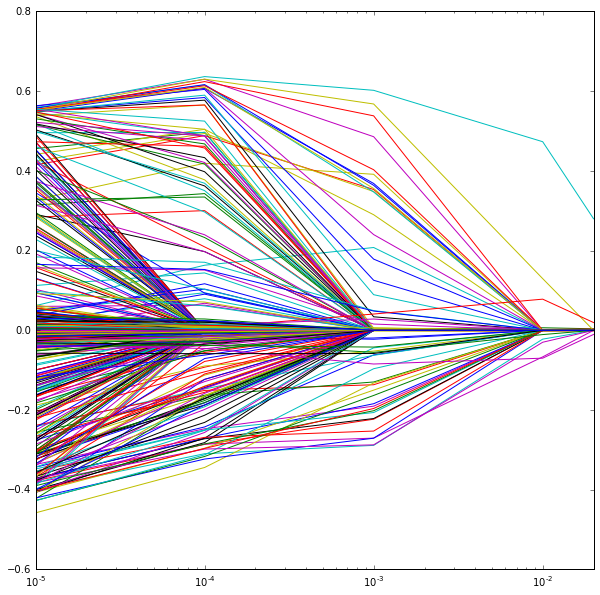

In [51]:
ax = lpd.plot(legend=False, figsize=(10, 10), logx=True)
ax